Multi-arm Bandits
------

![](http://i1.wp.com/banditalgs.com/wp-content/uploads/2016/09/cropped-bandit-algorithm-full.png?fit=512%2C512)

In [14]:
reset -fs

In [462]:
import math
import random
import scipy as sp



import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from math import factorial
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/nlp_founder/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
class Bandits:

    def __init__(self, p_array):
        self.p_array = p_array            # Array of probabilities to initialize bandits
        self.optimal = np.argmax(p_array) # Index of the optimal bandit

    def pull(self, index):
        "Sample from a given bandit"
        return np.random.random() < self.p_array[index] # Boolean indicating whether the bandit returned a reward or not

    def __len__(self):
        return len(self.p_array)

In [685]:
class BanditStrategy:
    " Implements a online, learning strategy to solve the Multi-Armed Bandit problem."

    def __init__(self, bandits, choice_function):
        self.bandits = bandits                 # Instance of Bandits class
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0                             # The cumulative number of samples
        self.choices = []                      # The historical choices 
        self.score = []                        # The historical score 
        self.choice_function = choice_function # Has self argument to gives access to all the instance variables
                                               # Returns and int between 0 and n-1
        self.regret = []  # store regret over time

    def sample_bandits(self, n=1):
        "Simulate n rounds of running the bandit machine."
        score = np.zeros(n)
        choices = np.zeros(n)

        # Seed the random number generators so you get the same results every time.
        np.random.seed(42)
        random.seed(42)

        for k in range(n):
            # Sample from the bandits's priors, and select the largest sample
            choice = self.choice_function(self)

            # Sample the chosen bandit
            result = self.bandits.pull(choice)

            # Update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            score[k] = result
            self.N += 1
            choices[k] = choice

        self.score = np.r_[self.score, score]
        self.choices = np.r_[self.choices, choices]
        
        

    def regret(self, probabilities):
        """Take an array of the true probabilities for each machine and 
        an array of the indices of the machine played at each round.
        Return an array giving the total regret after each round."""
        p_opt = np.max(probabilities)
        return np.cumsum(p_opt - probabilities[self.choices.astype(int)]) # Total Regret

    def optimum_choices(self, probabilities):
        """Take an array of the true probabilities for each machine and 
        an array of the indices of the machine played at each round.
        Return an array giving the total regret after each round.
        """
        p_opt = np.argmax(probabilities)
        return np.cumsum(np.select([self.choices==p_opt], [1]))

    def max_mean(self):
        "Pick the bandit with the current best observed proportion of winning."
        if len(self.trials.nonzero()[0]) < len(self.bandits): # Make sure to play each bandit at least once
            return np.random.randint(0, len(self.bandits))
        return np.argmax(self.wins / (self.trials + 1)) # Return the index of the winning bandit.

In [686]:
def random_choice(self): # XXX: This is silly technical debt. This method depends on some j-random classs!
    "Pick a bandit uniformly at random."
    return np.random.randint(0, len(self.wins)) # Return the index of the winning bandit.

In [687]:
bandits = Bandits([0.05, 0.03, 0.06])
bs = BanditStrategy(bandits, random_choice)
bs.sample_bandits(10) # 1000 is a good value

In [688]:
def print_results(bs_instance):
    print("Number of trials: ", bs_instance.trials)
    print("Number of wins: ", bs_instance.wins)
    print("Conversion rates: ", bs_instance.wins / bs_instance.trials)
    print(f"A total of {bs_instance.wins.sum()} wins of {bs_instance.trials.sum()} trials.")

In [689]:
print_results(bs)

Number of trials:  [ 3.  3.  4.]
Number of wins:  [ 0.  0.  1.]
Conversion rates:  [ 0.    0.    0.25]
A total of 1.0 wins of 10.0 trials.


-----
Implement the four multi-arm bandit strategies: 
        
1. epsilon-greedy
2. softmax
3. ucb1 
4. bayesian bandits

In [748]:
def regret(probabilities, choices):
        '''
        INPUT: array of floats (0 to 1), array of ints
        OUTPUT: array of floats

        Take an array of the true probabilities for each machine and an
        array of the indices of the machine played at each round.
        Return an array giving the total regret after each round.
        '''
        p_opt = np.max(probabilities)


        return np.sum(p_opt - probabilities)

In [749]:
def epsilon_greedy(self, epsilon=0.1):
    '''
    Pick a bandit uniformly at random epsilon percent of the time.
    Otherwise pick the bandit with the best observed proportion of winning.
    Return the index of the winning bandit.
    '''
    
    if np.random.rand() < epsilon: # pick random bandit 
        winner = np.random.randint(0, len(self.wins)) 

        self.regret.append(regret(np.array( (self.wins+1) / (self.trials+1) ),winner))
        
        return np.random.randint(0, len(self.wins)) # Return the index of the winning bandit.
    
    else: # pick bandit with highest conversion rate
        winner = np.argmax(self.wins+1 / self.trials+1)
        
        self.regret.append(regret(np.array( (self.wins+1) / (self.trials+1)),winner))
        return winner # conversion rates for all the bandits
        

In [764]:
def softmax(self, tau=0.01):
    '''
    Pick an bandit according to the Boltzman Distribution.
    Return the index of the winning bandit.
    '''

    conversion_rates = np.array( (self.wins +1)  / (self.trials.astype(float) + 1.0))
    prob = np.exp(conversion_rates/ tau)
    winner = np.argmax(prob/ np.sum(prob))
    self.regret.append( regret(np.array(prob/ np.sum(prob))   ,winner))
    
    return winner


    

In [820]:
def ucb1(self):
    '''
    Pick the bandit according to the UCB1 strategy.
    Return the index of the winning bandit.
    '''
    from math import sqrt
    
    conversion_rates = np.array( (self.wins +1)  / (self.trials.astype(float) + 1.0))
    winner = np.argmax(conversion_rates + np.sqrt(((2*np.log(len(conversion_rates)))+1)/(self.wins+1)))
    
    #print([conversion_rates + np.sqrt(2*np.log(self.N+1)/(self.wins))])
    self.regret.append( regret(np.array( [conversion_rates + np.sqrt(((2*np.log(len(conversion_rates)))+1)/(self.wins+1))] ) ,winner))
    
    return winner


In [825]:
def bayesian_bandit(self):
    '''
    Randomly sample from a beta distribution for each bandit and pick the one
    with the largest value.
    Return the index of the winning bandit.
    '''

    alpha = 1 # prior belief
    beta = 1 # prior belief
    rand_sample = np.zeros(len(self.bandits))

    for bandit_idx in range(len(self.bandits)):
        # beta posterior
        rand_sample[bandit_idx] = stats.beta(alpha+self.trials[bandit_idx], 
                                             beta +self.trials[bandit_idx] - self.wins[bandit_idx]).rvs()
        
    winner = np.argmax(rand_sample)
    self.regret.append( regret(rand_sample  ,winner))
    
    return np.argmax(rand_sample)
    

    pass

See how many wins you have of the 1000 trials using each of the six strategies (two already implemented) with the starting bandits given above.

In [747]:
np.sum(0.333333333333 - np.array([ 0.33333333 , 0.25      ,  0.09090909]))

0.32575757999900012

In [767]:
bandits = Bandits([0.05, 0.03, 0.06])
#bs = BanditStrategy(bandits, epsilon_greedy)
bs = BanditStrategy(bandits, softmax)
#bs = BanditStrategy(bandits, ucb1)
#bs = BanditStrategy(bandits, bayesian_bandit)
bs.sample_bandits(2000)
print_results(bs)

Number of trials:  [ 1943.    38.    19.]
Number of wins:  [ 103.    1.    0.]
Conversion rates:  [ 0.05301081  0.02631579  0.        ]
A total of 104.0 wins of 2000.0 trials.


What is your summary of the different strategies?

In [ ]:
# Bayesian bandits perform the best overall, although it is much slower to compute that other methods (104 wins in 2k traisl)
# UCB: is too optimistic for probabilities that are slightly lower than the other options (81 wins in 2k traias)
# Softmax: finds one arm that performs the best and then only picks that arm  (104 wins in 2k trials)
# Greedy: only exploits one arm over time (97 wins over 2k trials)



Try running it again  and see how different each algorithm does with respect to


In [524]:
probs ={'atlantic_city': [0.1, 0.1, 0.1, 0.1, 0.9],
        'las_vegas': [0.1, 0.1, 0.1, 0.1, 0.12],
        'reno': [0.1, 0.2, 0.3, 0.4, 0.5]}

bandits = Bandits(probs['atlantic_city'])

In [526]:
#bs = BanditStrategy(bandits, epsilon_greedy)
bs = BanditStrategy(bandits, softmax)
#bs = BanditStrategy(bandits, ucb1)
#bs = BanditStrategy(bandits, bayesian_bandit)
bs.sample_bandits(2000)
print_results(bs)

Number of trials:  [  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.99600000e+03]
Number of wins:  [    0.     0.     0.     0.  1800.]
Conversion rates:  [ 0.          0.          0.          0.          0.90180361]
A total of 1800.0 wins of 2000.0 trials.


In [ ]:
# Greedy: 1671 wins in 2k trials
# Softmax: 1800 wins in 2k trals
# UCB: 1250 wins in 2k trials
# Bayesian: 1772 traisl in 2k trals

In [ ]:
# Softmax performs the best here due to the large discrepancy in the probabilities associated with each bandit 

What is your summary of the different strategies?

In [ ]:
# Thompson sampling performs well under uncertainity 
# Softmax: coverges to one arm very quickly when it finds that best
# UCB: Pretty optimisic and tends to assign more trials to arm that are not as good, would be 
# better with more uncertain reward probabilities
# Greedy: Simple to implement but always assigns a fixed percent of trials to exploration if you do not annel epsilon


In [625]:
.3 - np.array([.3,.3,.3])[2]

0.0

In [ ]:
[0,0,1]

Plot the total regret over time of each algorithm. 

Use the Bandits with these hidden probabilities:

In [528]:
bandits = Bandits([0.05, 0.03, 0.06])

In [843]:
bs = BanditStrategy(bandits, epsilon_greedy)
#bs = BanditStrategy(bandits, softmax)
#bs = BanditStrategy(bandits, ucb1)

#bs = BanditStrategy(bandits, bayesian_bandit)
bs.sample_bandits(2000)
print_results(bs)

Number of trials:  [   61.    75.  1864.]
Number of wins:  [   3.    2.  104.]
Conversion rates:  [ 0.04918033  0.02666667  0.05579399]
A total of 109.0 wins of 2000.0 trials.


/Users/jonathanhilgart/anaconda/envs/nlp_founder/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


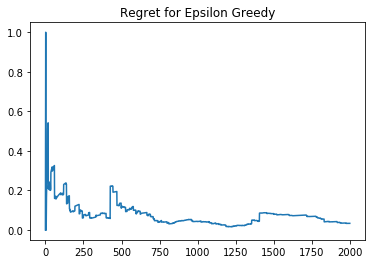

In [762]:
plt.title('Regret for Epsilon Greedy')
plt.plot(bs.regret)

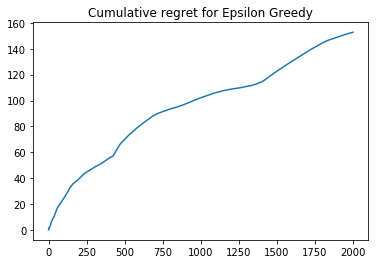

In [763]:
plt.title('Cumulative regret for Epsilon Greedy')
plt.plot(np.cumsum(bs.regret))

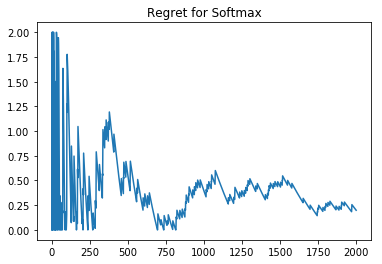

In [757]:
plt.title('Regret for Softmax')
plt.plot(bs.regret)

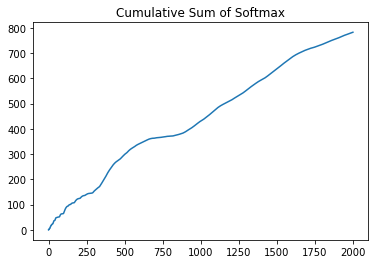

In [760]:
plt.plot(np.cumsum(bs.regret))
plt.title('Cumulative Sum of Softmax')

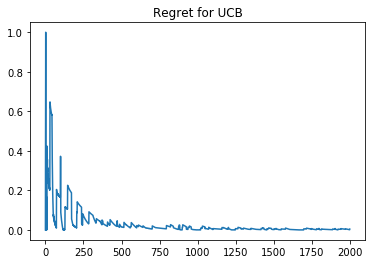

In [822]:
plt.title('Regret for UCB')
plt.plot(bs.regret);

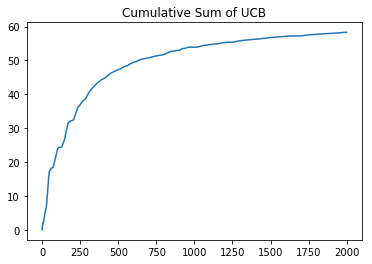

In [823]:
plt.plot(np.cumsum(bs.regret))
plt.title('Cumulative Sum of UCB');

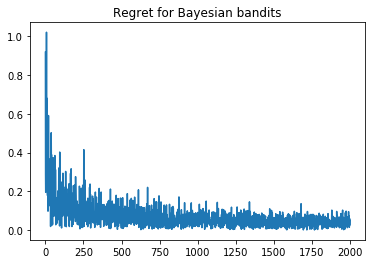

In [827]:
plt.title('Regret for Bayesian bandits')
plt.plot(bs.regret);

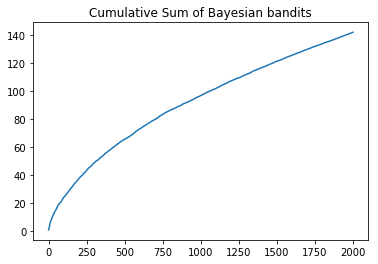

In [828]:
plt.plot(np.cumsum(bs.regret))
plt.title('Cumulative Sum of Bayesian bandits');

Now plot the percentage of time the optimal bandit was chosen over time.

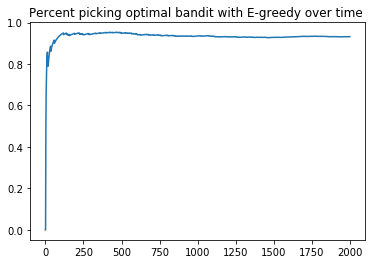

In [844]:
plt.title("Percent picking optimal bandit with E-greedy over time ")
plt.plot(np.cumsum(bs.choices==2)/np.array([_ for _ in range(1,len(bs.choices)+1)]));

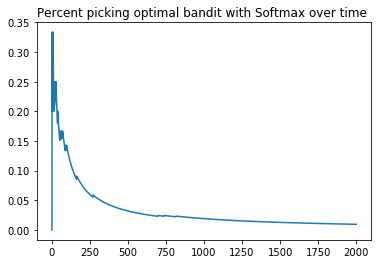

In [842]:
plt.title("Percent picking optimal bandit with Softmax over time ")
plt.plot(np.cumsum(bs.choices==2)/np.array([_ for _ in range(1,len(bs.choices)+1)]));

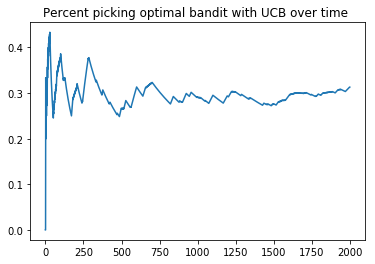

In [840]:
plt.title("Percent picking optimal bandit with UCB over time ")
plt.plot(np.cumsum(bs.choices==2)/np.array([_ for _ in range(1,len(bs.choices)+1)]));

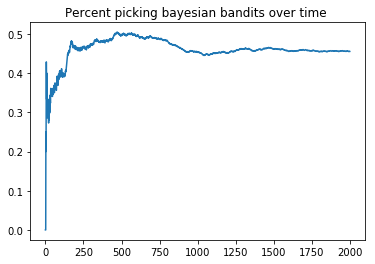

In [837]:
plt.title("Percent picking bayesian bandits over time ")
plt.plot(np.cumsum(bs.choices==2)/np.array([_ for _ in range(1,len(bs.choices)+1)]))

<br>
<br> 
<br>

----